# Data Preparation for Most Improved Player

In this notebook we will prepare the data for the Most Improved Player award prediction.

#### Load Dependencies

In [19]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player performance statistics for analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.  
- **Convert Key Stats to Float:** Ensure important performance statistics are numeric for accurate calculations.  
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.
- **Add Season 11 Data:** Include additional data from Season 11 for completeness.
- **Sort Data:** Organize the aggregated data by player and year to facilitate multi-year performance score computations.

In [20]:
improved_players_info_df = sd.players_teams_df.copy()

cols_to_agg = ['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgMade', 'fgAttempted', 'GP', 'minutes', 'GS']

for col in cols_to_agg:
    improved_players_info_df[col] = improved_players_info_df[col].astype(float)

# Adding data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")

improved_players_info_df = pd.concat([improved_players_info_df, players_teams_year11_df], ignore_index=True)

improved_players_info_df = improved_players_info_df.groupby(['playerID', 'year'], as_index=False)[cols_to_agg].sum()

improved_players_info_df = improved_players_info_df.sort_values(['playerID', 'year'])

#### Compute Overall Performance Score Function

This section defines a function to calculate an overall performance score for each player per season:

- **Normalize by Games Played:** Adjust statistics to account for differences in games played.  
- **Weight Key Stats:** Apply weights to points, rebounds, assists, steals, blocks, turnovers, and field goal percentage to reflect their impact on overall performance.  
- **Compute Overall Score:** Combine the weighted stats into a single performance score for each player per season.

In [21]:
def overall_performance(PTS, REB, AST, STL, BLK, TOV, FGM, FGA, GP):
    if GP == 0 or FGA == 0:
        return 0 
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )


#### Calculate Multi-Year Performance Scores

This section computes multi-year performance scores for each player:

- **Previous Seasons:** Calculate performance scores for the past 1, 2, and 3 years.  
- **Use `overall_performance` Function:** Apply the function to generate per-season performance scores.  
- **Create Lagged Features:** Generate lagged statistics to capture trends over multiple seasons, useful for predictive modeling.

In [22]:
for shift_years in [1, 2, 3]:
    col_suffix = f"prev_{shift_years}yr"

    
    shifted_points = improved_players_info_df.groupby('playerID')['points'].shift(shift_years)
    shifted_assists = improved_players_info_df.groupby('playerID')['assists'].shift(shift_years)
    shifted_turnovers = improved_players_info_df.groupby('playerID')['turnovers'].shift(shift_years)
    shifted_fgMade = improved_players_info_df.groupby('playerID')['fgMade'].shift(shift_years)
    shifted_fgAttempted = improved_players_info_df.groupby('playerID')['fgAttempted'].shift(shift_years)
    shifted_gp = improved_players_info_df.groupby('playerID')['GP'].shift(shift_years)
    shifted_rebounds = improved_players_info_df.groupby('playerID')['rebounds'].shift(shift_years)
    shifted_steals = improved_players_info_df.groupby('playerID')['steals'].shift(shift_years)
    shifted_pf = improved_players_info_df.groupby('playerID')['blocks'].shift(shift_years)

    
    overall_performance_scores = pd.Series(
        [overall_performance(
            shifted_points.iloc[i], shifted_rebounds.iloc[i], shifted_assists.iloc[i],
            shifted_steals.iloc[i], shifted_pf.iloc[i], shifted_turnovers.iloc[i],
            shifted_fgMade.iloc[i], shifted_fgAttempted.iloc[i], shifted_gp.iloc[i])
         for i in range(len(improved_players_info_df))],
        index=improved_players_info_df.index
    )
    
    improved_players_info_df[f'overall_score_{col_suffix}'] = overall_performance_scores.fillna(0)

#### Calculate Player Usage by Minute Ranges

This section categorizes players based on their playing time in the previous season:

- **Previous Minutes:** Retrieve minutes played from the prior year.  
- **Categorize Usage:** Bin minutes into categories (low, medium, high) to indicate player usage levels.  
- **Add Feature:** Include this as a feature for modeling, as usage can affect improvement potential.

In [23]:
improved_players_info_df['minutes_prev_year'] = (
    improved_players_info_df.groupby('playerID')['minutes'].shift(1)
).fillna(0)

improved_players_info_df['minutes_category'] = pd.cut(
    improved_players_info_df['minutes_prev_year'],
    bins=[-1, 136, 680, float('inf')],
    labels=[0, 1, 2]
).astype('Int64')

#### Merge Improved Player Award Information

This step incorporates the target variable for modeling player improvement:

- **Add Award Indicator:** Create a column showing whether the player won Most Improved Player (1) or not (0) for each season.  
- **Merge with Player Data:** Combine award information with the prepared player dataset.  
- **Prepare for Modeling:** Ensure the dataset includes both features (performance scores) and the target variable for predictive analysis.

In [24]:
improved_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'most improved player'].drop_duplicates(subset=['playerID', 'year']).copy()
improved_aw['improved'] = 1

improved_players_info_df = improved_players_info_df.merge(
    improved_aw[['playerID', 'year', 'improved']],
    on=['playerID', 'year'],
    how='left'
)
improved_players_info_df['improved'] = improved_players_info_df['improved'].fillna(0).astype(int)

#### Column to Check Players Who Have Won the Award in Past Years

This section adds a feature to track prior award wins:

- **Cumulative Wins:** Calculate the running total of awards won by each player up to the previous year.  
- **Prevent Multiple Wins:** This helps exclude players who have already won, as they are ineligible for future awards.  
- **Eligibility Check:** Use this to filter the dataset for modeling purposes.

In [25]:
df = improved_players_info_df.sort_values(['playerID', 'year'])

improved_players_info_df['has_won_before'] = (
    df.groupby('playerID')['improved']
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype(int)
)

#### Remove Rows and Columns and Save CSV

This step finalizes the dataset for modeling:

- **Remove Rows:** Exclude rookies (no prior year to improve from) and prior award winners, whose previous strong improvements give them a higher baseline, making further improvement less comparable to other players.
- **Remove Columns:** Discard irrelevant or redundant columns to focus on key features.  
- **Save to CSV:** Export the processed dataset to a CSV file for use in predictive modeling.  
- **Ready for Analysis:** Ensure the dataset is clean, organized, and contains all necessary features and target variables.

In [26]:
first_years = improved_players_info_df.groupby('playerID')['year'].transform('min')
improved_players_info_df = improved_players_info_df[improved_players_info_df['year'] != first_years]
improved_players_info_df = improved_players_info_df[improved_players_info_df['has_won_before'] == 0]

columns_to_drop = [
     'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds',
     'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF',
     'fgMade', 'fgAttempted', 'threeMade', 'threeAttempted',
     'ftMade', 'ftAttempted', 'PostthreeMade', 'PostthreeAttempted',
     'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds',
     'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks',
     'PostTurnovers', 'PostPF', 'PostfgMade', 'PostfgAttempted', 'PostthreeMade',
     'PostthreeAttempted', 'PostftMade', 'PostftAttempted', 'PostDQ',
     'height', 'weight', 'pos', 'birthDate', 'deathDate', 'minutes_prev_year', 'has_won_before'
]
improved_players_info_df.drop(columns=[col for col in columns_to_drop if col in improved_players_info_df.columns], inplace=True)

improved_players_info_df.to_csv("../predict_datasets/mip.csv", index=False)

#### Idea For the Dataset Preparation

Since this dataset is for the Most Improved Player award, we calculated the overall performance score for each player to track changes in their performance, indicating potential improvement and highlighting whether a player still has significant room to grow.

We also incorporated a playing-time category, as the award typically recognizes players who previously had limited roles. Players were divided into three groups:

- Minimal Playing Time: Players who rarely appeared in games. They are unlikely to make the dramatic jump to impactful starters required to win this award.

- Bench Players with Moderate Minutes or Starters with Low Minutes: This group includes role players with some playing time and starters whose on-court minutes were previously limited.

- Starters with High Minutes: Established starters with consistently high minutes are less likely to show the significant year-over-year improvement the award seeks to honor.

This categorization helps identify the most viable candidates, as the greatest improvements typically come from the second group, players who previously had a modest role and are now poised to become key contributors.

#### Data Correlation Analysis

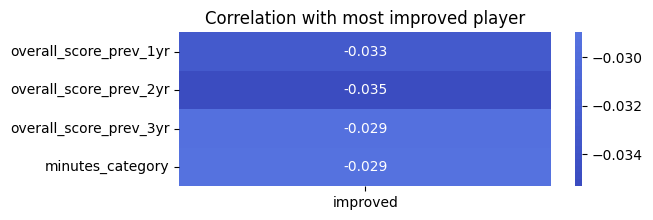

In [27]:
score_cols = ['overall_score_prev_1yr', 'overall_score_prev_2yr', 'overall_score_prev_3yr', 'minutes_category', 'improved']
df_scores = improved_players_info_df[score_cols]

corr_matrix = df_scores.corr()[['improved']]

corr_matrix = corr_matrix.drop('improved')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with most improved player")
plt.show()